In [10]:
from datetime import datetime
start_real = datetime.now() # 全体の処理時間の計測を開始する

#### ライブラリのインポート

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import load_npz

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
import optuna

import warnings
warnings.simplefilter("ignore")

#### X と y の読み込み

In [12]:
# Kaggle Notebook
X = load_npz('/kaggle/input/mercari-preprocessed/X.npz')
y = pd.read_csv('/kaggle/input/mercari-preprocessed/y.csv')

#### モデルの作成と学習

#### X と y のうち、7割を訓練用 (train)、3割を検証用 (test) に分割する

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1032740, 186740)
(1032740, 1)
(442604, 186740)
(442604, 1)


#### モデルの学習｜Ridge回帰

In [15]:
# RMSLEを計算する関数
def rmsle(y_true, y_pred):
    # クリップして無限大や非常に大きな値を避ける
    y_true_clipped = np.clip(y_true, 0, np.log(np.finfo(np.float64).max))
    y_pred_clipped = np.clip(y_pred, 0, np.log(np.finfo(np.float64).max))
    
    return np.sqrt(mean_squared_log_error(y_true_clipped, y_pred_clipped))

In [16]:
# 最適化する目的関数の定義
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e+2)  # 正則化パラメータ
    
    # モデルの定義
    ridge = Ridge(alpha=alpha, fit_intercept=True, solver='lsqr', random_state=0)
    ridge.fit(X_train, y_train)

    y_pred = ridge.predict(X_test)
    return rmsle(y_test, y_pred)

In [17]:
%%time
# Optunaによる最適化
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)  # 25回の試行

[I 2024-10-08 09:53:35,970] A new study created in memory with name: no-name-4d42eee5-9a29-4c26-ac03-bc49fbf71720
[I 2024-10-08 09:56:28,836] Trial 0 finished with value: 0.11741863723807336 and parameters: {'alpha': 0.310863316854674}. Best is trial 0 with value: 0.11741863723807336.
[I 2024-10-08 09:59:51,933] Trial 1 finished with value: 0.11872731938938298 and parameters: {'alpha': 0.001325806692653004}. Best is trial 0 with value: 0.11741863723807336.
[I 2024-10-08 10:03:14,178] Trial 2 finished with value: 0.11871198030161902 and parameters: {'alpha': 0.003706471679564282}. Best is trial 0 with value: 0.11741863723807336.
[I 2024-10-08 10:06:36,359] Trial 3 finished with value: 0.1185359788051704 and parameters: {'alpha': 0.03224085987215192}. Best is trial 0 with value: 0.11741863723807336.
[I 2024-10-08 10:08:28,295] Trial 4 finished with value: 0.11547930225810207 and parameters: {'alpha': 2.945078782292823}. Best is trial 4 with value: 0.11547930225810207.
[I 2024-10-08 10:09

CPU times: user 1h 37min 39s, sys: 1h 8min 7s, total: 2h 45min 46s
Wall time: 55min 10s


In [18]:
# 最適なハイパーパラメータの表示
print("Best parameters:", study.best_params)
print("Best RMSLE from cross-validation:", study.best_value)

Best parameters: {'alpha': 4.3873371550240865}
Best RMSLE from cross-validation: 0.11537969783385026


In [19]:
%%time
# 最適なモデルで学習を行う
ba = study.best_params['alpha']
br = Ridge(alpha=ba, fit_intercept=True, solver='lsqr', random_state=0)
br.fit(X_train, y_train)

CPU times: user 2min 47s, sys: 1min 59s, total: 4min 47s
Wall time: 1min 34s


Ridge(alpha=4.3873371550240865, random_state=0, solver='lsqr')

#### 訓練データに対する予測｜Ridge回帰

In [20]:
y_train_pred = br.predict(X_train)

In [21]:
# 元のスケールに戻す
y_train_cp = y_train.copy()
y_train_pred_cp = y_train_pred.copy()

y_train_cp = np.expm1(y_train_cp)
y_train_pred_cp = np.expm1(y_train_pred_cp)

In [22]:
y_min = np.append(y_train_pred_cp, y_train_cp).min()
y_max = np.append(y_train_pred_cp, y_train_cp).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

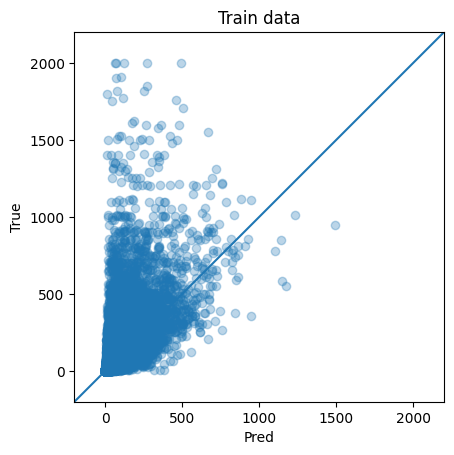

In [23]:
plt.scatter(y_train_pred_cp, y_train_cp, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [24]:
# モデルの評価
ridge_train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred))
print("RMSLE for train data:", ridge_train_rmsle)

RMSLE for train data: 0.43047238485509054


#### テストデータに対する予測｜Ridge回帰

In [25]:
y_test_pred = br.predict(X_test)

In [26]:
# 元のスケールに戻す
y_test_cp = y_test.copy()
y_test_pred_cp = y_test_pred.copy()

y_test_cp = np.expm1(y_test_cp)
y_test_pred_cp = np.expm1(y_test_pred_cp)

In [27]:
y_min = np.append(y_test_pred_cp, y_test_cp).min()
y_max = np.append(y_test_pred_cp, y_test_cp).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

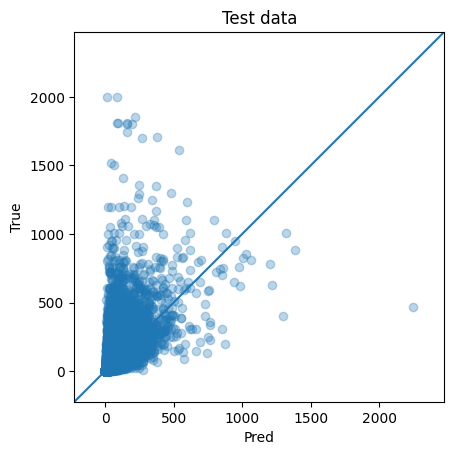

In [28]:
plt.scatter(y_test_pred_cp, y_test_cp, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [29]:
# モデルの評価
ridge_test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred))
print("RMSLE for test data:", ridge_test_rmsle)

RMSLE for test data: 0.45930446376411416


In [30]:
stop_real = datetime.now()
execution_time_real = stop_real - start_real
print(execution_time_real)

0:56:53.945978
